In [11]:
%matplotlib inline

In [12]:
import numpy as np
from qreservoirpy import QReservoir, Layers, utilities
from qiskit.circuit.library.standard_gates import HGate, SGate, CXGate


In [13]:
n_qubits = 100
shots = 10000
circop = utilities.random_circuit(n_qubits, gates=[
    HGate, SGate, CXGate
], depth=20)
op = circop.to_gate(label='RES')
# circop.draw('mpl')


In [14]:
target = [0, 0, 0, 1] * 30
def build_method(circ, timestep, operator, encoder):
    for i in range(4):
        circ.measure(i)
        circ.initialize(encoder[timestep], [i])
    circ.append(operator,circ.qubits)
    return circ

res = QReservoir(
    qubits=n_qubits, 
    layers=[
        Layers.H(),
        Layers.Timeseries(build_method=build_method),
    ], 
    operator=op, 
    encoder={
        0: '0',
        1: '1',  
    })
states = res.run(target, shots=shots, transpile=True, simulator='aer_simulator_stabilizer', disable_status_bar=False)
# res.circuit.draw('mpl')


Simulating: 100%|██████████| 1/1 [01:11<00:00, 71.48s/it]


[[0.4975 0.5    0.5084 0.5029]
 [0.5035 0.5053 0.507  0.5009]
 [0.4986 0.5062 0.5022 0.4951]
 [0.5076 0.4966 0.4975 0.4973]
 [0.5046 0.502  0.5018 0.4953]
 [0.5025 0.4973 0.4951 0.4984]
 [0.5077 0.4886 0.5051 0.4925]
 [0.4935 0.4976 0.5076 0.5032]
 [0.513  0.5051 0.4936 0.5011]
 [0.499  0.4995 0.4899 0.4928]
 [0.4994 0.5147 0.4971 0.5005]
 [0.5047 0.4972 0.512  0.503 ]
 [0.4916 0.5017 0.5006 0.5019]
 [0.5022 0.5116 0.4969 0.5075]
 [0.5016 0.5085 0.4981 0.5004]
 [0.4942 0.5062 0.5147 0.4986]
 [0.4969 0.5072 0.5041 0.4978]
 [0.4995 0.4989 0.5029 0.4986]
 [0.5004 0.5009 0.5001 0.5062]
 [0.5089 0.5064 0.4965 0.5016]
 [0.4992 0.5061 0.4928 0.4988]
 [0.4972 0.5065 0.5093 0.5022]
 [0.4964 0.5046 0.4994 0.5024]
 [0.5133 0.4938 0.5121 0.4862]
 [0.5012 0.5094 0.5086 0.4996]
 [0.4951 0.5034 0.4873 0.5124]
 [0.498  0.4949 0.4973 0.5029]
 [0.5031 0.4921 0.4962 0.4896]
 [0.4999 0.5061 0.503  0.5081]
 [0.5087 0.5041 0.4954 0.497 ]
 [0.5068 0.4944 0.4979 0.5006]
 [0.4988 0.4999 0.5047 0.5093]
 [0.5029

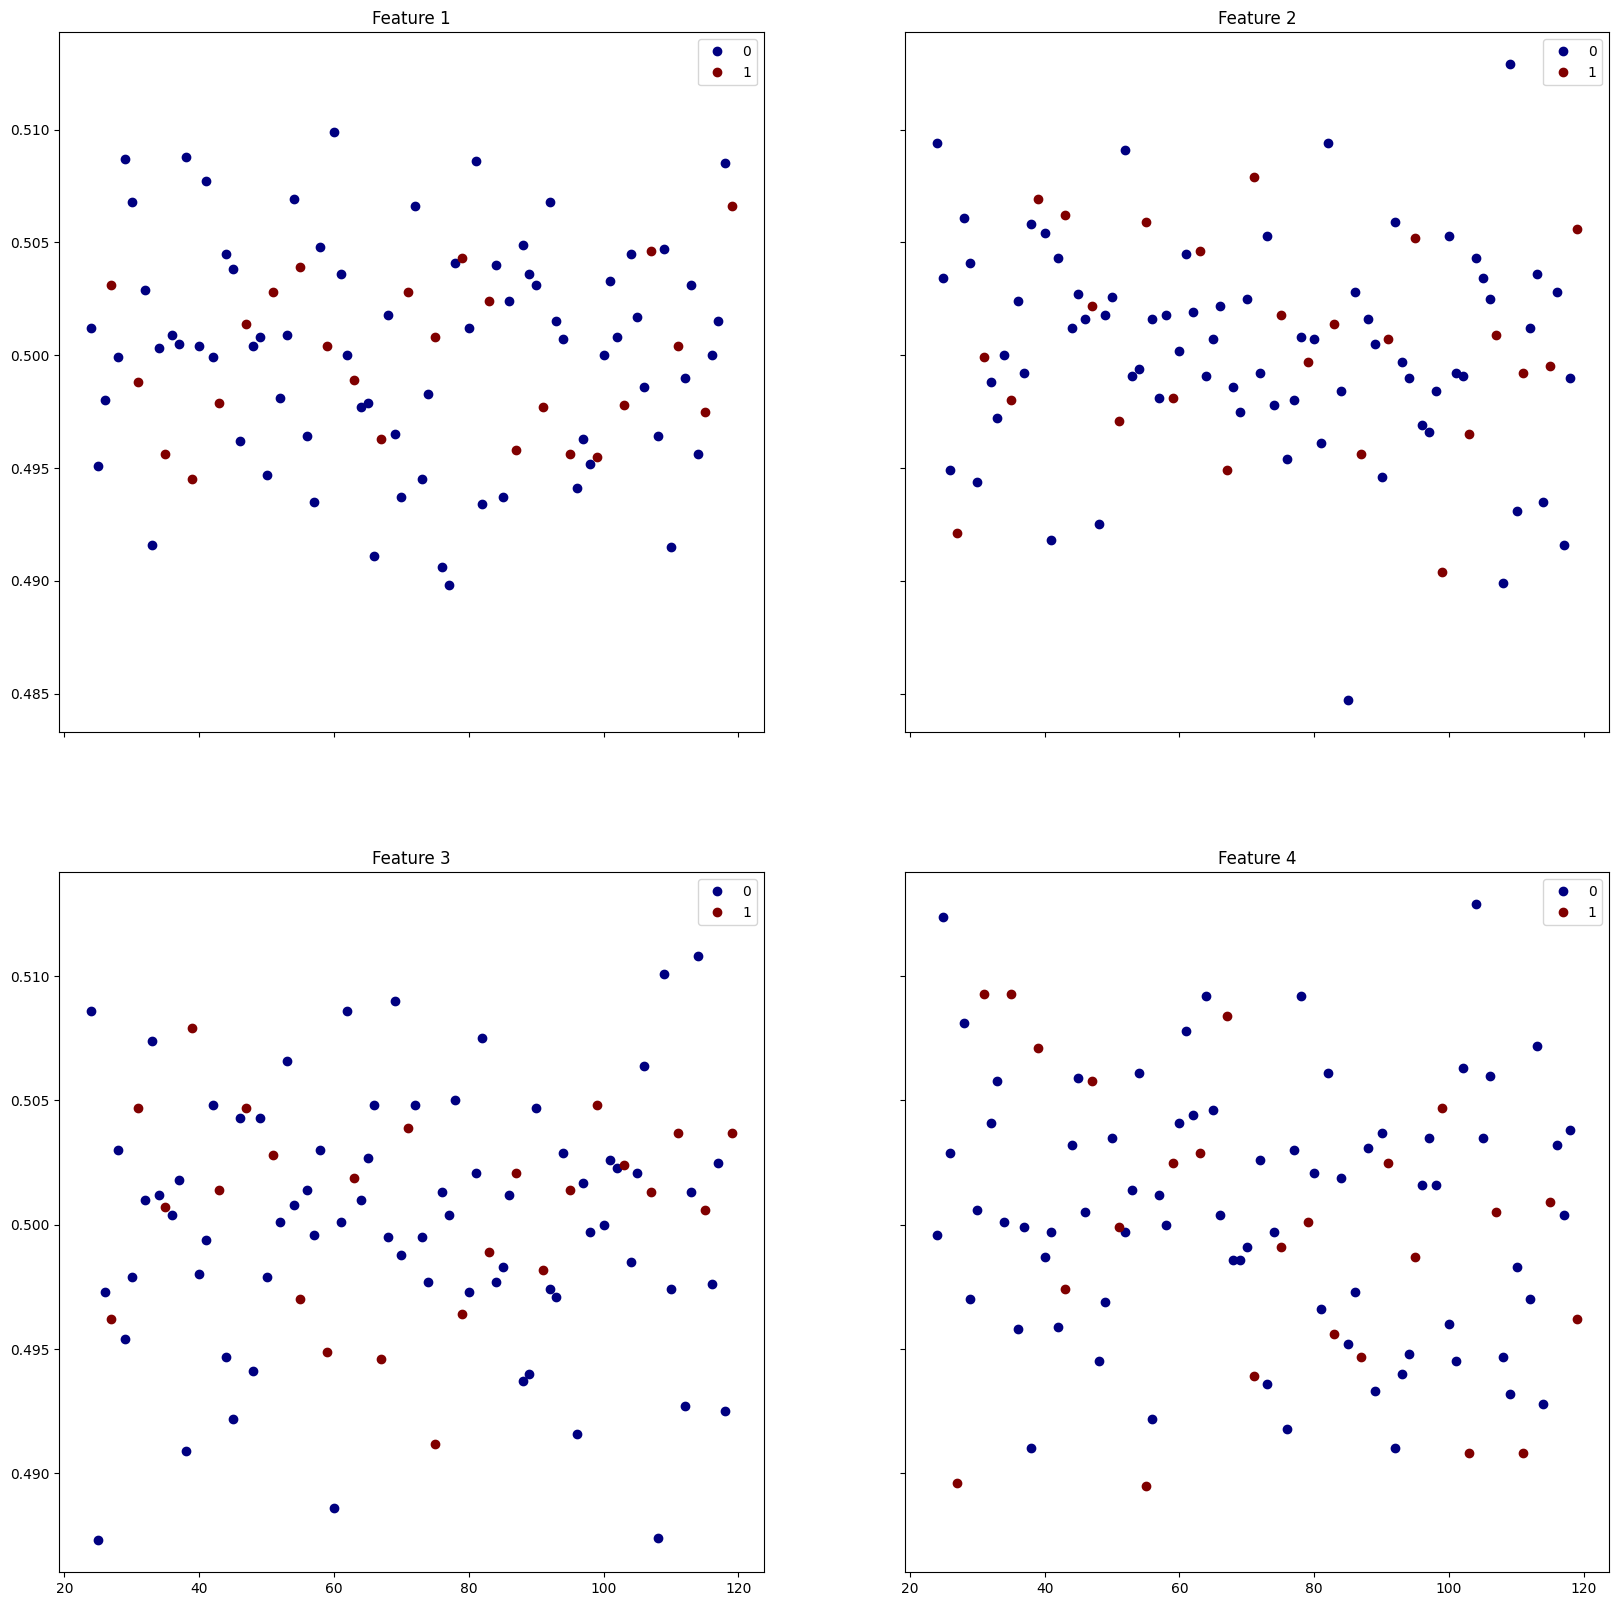

In [15]:
print(states)
fig ,axes = utilities.result_plotter(states, target, warmup=0.2)